# 1. Identifying fraudulent claims

You have a project with a new customer who has asked you to find a way to prioritize suspicious claims on the motor line of business, in order to help the investigators of the company on their daily work.

You have already started the project with the customer and after some initial meetings it has been possible to identify what data is needed and what data is available. Finally they have delivered to you the data in a csv file called claims.csv.



# 2. Data

The data that you will find here has the following information

|| |||
| --- ||||
| monthsascustomer | age | policy_number | policybinddate |
| policy_state | policy_csl | policy_deductable | policyannualpremium |
| umbrella_limit | insured_zip | insured_sex | insurededucationlevel |
| insured_occupation | insured_hobbies | insured_relationship | capital-gains |
| capital-loss | incident_date | incident_type | collision_type |
| incident_severity | authorities_contacted | incident_state | incident_city |
| incident_location | incidenthouroftheday | numberofvehicles_involved | property_damage |
| bodily_injuries | witnesses | policereportavailable | totalclaimamount |
| injury_claim | property_claim | vehicle_claim | auto_make |
| auto_model | auto_year | fraud_reported | _c39] |

# 3. Solution

Now is your turn. In the next step you need to develop a prototype with this data and show the customer your results and try to convince them that your model will offer an added value to the company. Good luck!!

---

The target variable is `fraud_reported`, which can assume a value in {0,1}.<br/>
The purpose of the model is to prioritize suspicious claims; we expect the target variable to be unbalanced with relatively few frauds.


In [1]:
import pandas as pd
from IPython.display import display, Markdown as md
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from collections import Counter
import math
from scipy import stats
from collections import defaultdict
from sklearn import preprocessing, model_selection

In [2]:
INPUT_FILE = "claims.csv"
df = pd.read_csv(INPUT_FILE)
y_name = "fraud_reported"
num_samples = len(df.index)

## 3.1 Missing values

What is the percentage of missing values in each column?

In [3]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
_c39,700,1.0
age,0,0.0
incident_state,0,0.0
incident_city,0,0.0
incident_location,0,0.0
incident_hour_of_the_day,0,0.0
number_of_vehicles_involved,0,0.0
property_damage,0,0.0
bodily_injuries,0,0.0
witnesses,0,0.0


We observe that only one column has 100% missing values and can be dropped. 

In [4]:
columns_to_drop = (missing_data[missing_data['Total'] > 10]).index
df = df.drop(columns_to_drop, axis=1)

## 3.2 Variable modifications

For each variable, we display the (max 10) most frequent values in [value, frequency] format.<br/>
It may be necessary to drop or modify columns.

After reviewing the variable values displayed below, we decide to:

Drop the following columns:
- `policy_number`: since it constitutes an ID
- `incident_location`: the incident may have happened at the same address in a different city or US state 
- `insured_zip`: there is a different ZIP for each sample; we are already using different geographical information (state, city)
- `insured_hobbies`: it is a detail of dubious relevance at a very high level of granularity, we keep the rest of the information about the customer (education, occupation)
- `policy_bind_date`, `incident_date`: replaced by `insurance_duration`

Turn several variables from categorical to numerical, because there is information in the order :
- `policy_csl`: {100/300, 250/500, 500/1000}, it makes more sense as a numerical variable
- `incident_severity`: {Trivial/Minor/Major Damage, Total Loss},
- `police_report_available`: NO=0, ?=1, YES=2
- `property_damage`: NO=0, ?=1, YES=2

Create the following columns:
- `insurance_duration`: it replaces the variables `policy_bind_date` and `incident_date` with their difference, in days

In [5]:
for c in df.columns:
    vc = df[c].value_counts(ascending=False).iloc[0:10]
    display(pd.DataFrame(vc))

,months_as_customer
289,6
259,6
230,6
210,6
140,6
285,5
107,5
128,5
156,5
245,5


,age
34,37
43,33
33,32
41,31
39,29
31,29
32,28
30,28
37,27
38,26


,policy_number
125591,1
836349,1
130930,1
413192,1
226725,1
533941,1
349658,1
756870,1
942106,1
432740,1


,policy_bind_date
2002-07-16,2
1997-02-03,2
1992-08-05,2
1995-09-19,2
2008-05-16,2
2002-12-28,2
1991-07-20,2
1995-12-07,2
1999-12-07,2
2006-01-01,2


,policy_state
OH,249
IL,237
IN,214


,policy_csl
100/300,259
250/500,248
500/1000,193


,policy_deductable
1000,250
500,231
2000,219


,policy_annual_premium
1281.25,2
1362.87,2
1389.13,2
1074.07,2
1073.83,2
1558.29,2
1453.61,1
1618.65,1
1927.87,1
1135.43,1


,umbrella_limit
0,557
6000000,38
5000000,34
4000000,28
7000000,21
3000000,8
8000000,7
2000000,3
9000000,2
10000000,1


,insured_zip
431202,2
450947,1
455689,1
607605,1
605408,1
475407,1
609317,1
442604,1
453193,1
445120,1


,insured_sex
FEMALE,370
MALE,330


,insured_education_level
JD,120
High School,105
Associate,105
Masters,99
MD,93
College,91
PhD,87


,insured_occupation
machine-op-inspct,66
exec-managerial,57
craft-repair,54
sales,54
prof-specialty,53
priv-house-serv,52
armed-forces,51
transport-moving,50
tech-support,50
other-service,47


,insured_hobbies
exercise,45
bungie-jumping,44
golf,42
movies,41
polo,41
paintball,40
kayaking,38
yachting,38
reading,38
camping,38


,insured_relationship
own-child,130
other-relative,126
husband,125
not-in-family,123
wife,105
unmarried,91


,capital-gains
0,347
51500,4
46300,4
51400,3
46700,3
38600,3
37900,3
59600,3
63600,3
67800,3


,capital-loss
0,343
-31400,4
-61400,4
-51000,4
-53800,4
-49400,3
-49200,3
-50300,3
-50000,3
-45800,3


,incident_date
2015-02-02,21
2015-01-24,17
2015-01-07,17
2015-02-04,17
2015-02-17,16
2015-01-21,16
2015-01-08,16
2015-02-23,16
2015-01-19,16
2015-01-09,15


,incident_type
Multi-vehicle Collision,302
Single Vehicle Collision,275
Vehicle Theft,68
Parked Car,55


,collision_type
Rear Collision,208
Side Collision,194
Front Collision,175
?,123


,incident_severity
Minor Damage,237
Major Damage,200
Total Loss,199
Trivial Damage,64


,authorities_contacted
Police,199
Fire,153
Ambulance,145
Other,143
None,60


,incident_state
NY,187
SC,178
WV,149
NC,78
VA,69
PA,21
OH,18


,incident_city
Springfield,117
Arlington,110
Columbus,108
Northbend,96
Hillsdale,96
Riverwood,90
Northbrook,83


,incident_location
7082 Oak Ridge,1
5663 Oak Lane,1
2376 Sky Ridge,1
3900 Texas St,1
8809 Flute St,1
2651 MLK Lane,1
6260 5th Lane,1
9633 MLK Lane,1
3799 Embaracadero Drive,1
3246 Britain Ridge,1


,incident_hour_of_the_day
17,38
3,36
23,36
4,35
0,35
16,35
13,34
10,32
14,31
21,31


,number_of_vehicles_involved
1,398
3,251
4,28
2,23


,property_damage
?,259
NO,223
YES,218


,bodily_injuries
0,236
2,232
1,232


,witnesses
1,181
0,177
2,173
3,169


,police_report_available
?,247
NO,236
YES,217


,total_claim_amount
75400,4
2640,4
57700,3
77440,3
4320,3
79800,3
46200,3
84590,3
4950,3
58300,3


,injury_claim
0,19
480,7
780,5
640,5
900,4
860,4
5540,4
680,4
9880,3
13520,3


,property_claim
0,14
480,4
640,4
11080,4
860,4
660,4
680,4
840,4
6620,4
8400,3


,vehicle_claim
5040,6
44800,5
3600,5
33600,5
3360,4
25200,3
2940,3
46000,3
4340,3
4720,3


,auto_make
Suburu,57
Nissan,56
Saab,56
Toyota,55
Chevrolet,54
Volkswagen,54
Audi,51
Ford,49
Dodge,49
BMW,48


,auto_model
Wrangler,31
RAM,29
A3,28
Passat,28
Jetta,26
A5,23
Legacy,23
Pathfinder,23
MDX,23
Forrestor,22


,auto_year
1995,42
2002,41
2009,40
2006,38
2005,38
2003,36
2013,36
1999,36
2000,35
2011,34


,fraud_reported
0,519
1,181


In [6]:
df_1 = df.drop(["policy_number", "incident_location", "insured_zip", "insured_hobbies"], axis=1)

df_1 = df_1.replace({"policy_csl": {"100/300": 1, "250/500": 2, "500/1000": 3},
                     "incident_severity": {"Trivial Damage": 0, "Minor Damage": 1, "Major Damage": 2, "Total Loss": 3},
                     "police_report_available": {"NO": 0, "?": 1, "YES": 2},
                     "property_damage": {"NO": 0, "?": 1, "YES": 2}})

a = pd.to_datetime(df["incident_date"], yearfirst=True)
b = pd.to_datetime(df["policy_bind_date"], yearfirst=True)
policy_time = a - b
df_1["insurance_duration"] = policy_time.dt.days
df_1 = df_1.drop(["incident_date", "policy_bind_date"], axis=1)

df = df_1

## 3.3 Numerical variables

First, we compute the **correlation between the input variables and target variable**. We use the Spearman correlation instead of Pearson's, to avoid relying on the linearity of the relationship between variables.<br/>
If the correlation has a very low absolute value (here, |corr|<0.04), we eliminate the input variable

In [7]:
# Find most important features relative to target
numerical_vars = df.select_dtypes(include=np.number).columns.tolist()
df_1 = df[numerical_vars]

corr = df_1.corr(method='spearman')
corr.sort_values([y_name], ascending=False, inplace=True)
print(corr[y_name].to_string(name=False))

relevant_vars =   [v for v in numerical_vars if abs(corr[y_name][v]) >= 0.04]
relevant_vars.remove(y_name)
vars_to_exclude = [v for v in numerical_vars if abs(corr[y_name][v]) < 0.04]
df = df.drop(vars_to_exclude, axis=1)
print("\n" + str(len(vars_to_exclude)) + " variables dropped: " + str(vars_to_exclude))
print("\n" + str(len(relevant_vars)) + " variables kept: " + str(relevant_vars))

fraud_reported                 1.000000
vehicle_claim                  0.142668
total_claim_amount             0.135830
incident_severity              0.125348
property_claim                 0.109286
injury_claim                   0.079860
witnesses                      0.073019
number_of_vehicles_involved    0.070372
property_damage                0.062993
umbrella_limit                 0.040850
policy_deductable              0.040671
bodily_injuries                0.024045
insurance_duration             0.021668
auto_year                      0.020425
incident_hour_of_the_day       0.014262
policy_annual_premium          0.000880
months_as_customer            -0.007532
police_report_available       -0.012268
capital-loss                  -0.017945
policy_csl                    -0.019269
age                           -0.021035
capital-gains                 -0.044315

10 variables dropped: ['months_as_customer', 'age', 'policy_csl', 'policy_annual_premium', 'capital-loss', 'incident_ho

It is also opportune to examine the **collinearity between input variables**. In datasets, having two variables with very high correlation (e.g. >0.8) means that they carry mostly the same information, in which case we have to keep only one.

Perfect collinearity is reached when one variable can be obtained as a linear combination of the other: <br/>
Given 2 input variables X1 and X2, $ \quad \forall i ( X1_i = \lambda_a X0_i + \lambda_b ) \quad$ and  $\quad correlation(X1_i, X2_i) = \pm 1$.

Representing correlation values in the heatmap below, we find that `injury_claim`, `property_claim`, and `vehicle_claim` are highly correlated to `total_claim_amount`. We decide to keep only `total_claim_amount`.

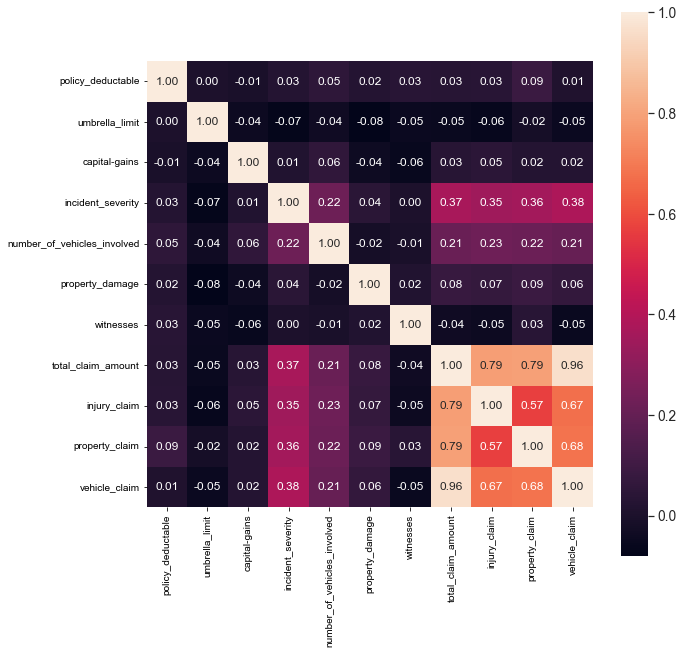

In [8]:
corr = corr[relevant_vars].loc[relevant_vars]

f, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.25)
ax = sns.heatmap(corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, 
                 xticklabels=corr.index, yticklabels=corr.index)
# plt.savefig(os.path.join("Correlation_matrix.png"))
# img = mpimg.imread(os.path.join("Correlation_matrix.png"))
df = df.drop(["injury_claim", "property_claim", "vehicle_claim"], axis=1)

### 3.3.1 Outliers and scaling

Before scaling the numerical features, we investigate the presence of outliers.

Outliers can be found using either:
- the inter-quartile range: a data point $x_i$ is an outlier if $x_i \lt Q1 – \frac{3}{2} \text{IQR}$ or $x_i \gt Q3 – \frac{3}{2} \text{IQR}$
- the standard deviation: $x_i$ is an outlier if it falls outside of $\mu \pm 3\cdot \sigma$. The data should follow a normal distribution

We decide to use the IQR, not wanting to rely on the columns following a normal distribution.

In the variable `umbrella_limit` more than half the values are =0 and the rest are ~$10^6$. We do not treat the outliers, in order not to lose the information they contain. The values will be scaled down to a more reasonable range.

Overall, the IQR check highlights only 1 outlier.

In [9]:
df_1 = df.copy(deep=True)
numerical_vars = df.select_dtypes(include=np.number).columns.tolist()
qs_dict = dict()

for nv in numerical_vars:
    values = df_1[nv].tolist()
    values.sort()  # default: ascending
    q1 = values[int(num_samples*0.25)]
    median = values[int(num_samples*0.5)]
    q3 = values[int(num_samples*0.75)]
    # print("\nVariable: " + nv)
    # print("Q1=" + str(q1) + " ; " + "Q3=" + str(q3) + " ; " + "IQR=" + str(q3-q1))
    qs_dict[nv] = (q1, q3)
    
for i, row in df_1.iterrows():
    for nv in numerical_vars:
        val = row[nv]
        q1 = qs_dict[nv][0]
        q3 = qs_dict[nv][1]
        iqr = q3 - q1
        if not q1==q3:  # a way to exclude 'umbrella_limit', where most values are 0
            if val < q1 - 1.5*iqr: 
                print("Variable:" + nv + "; found outlier=" + str(val) + " ; replacing with Q1=" + str(q1))
                df.at[i, nv] = q1
            if val > q3 + 1.5*iqr: 
                print("Variable:" + nv + "; found outlier=" + str(val) + " ; replacing with Q3=" + str(q3))
                df.at[i, nv] = q3

Variable:total_claim_amount; found outlier=114920 ; replacing with Q3=70290


We need to examine whether the numerical variables follow a normal distribution. If yes, then it is appropriate to standardize them so that they have $\mu=0$ and $\sigma=1$. If not, a simple MinMaxScaler can be used to bring the data in the range [0,1].

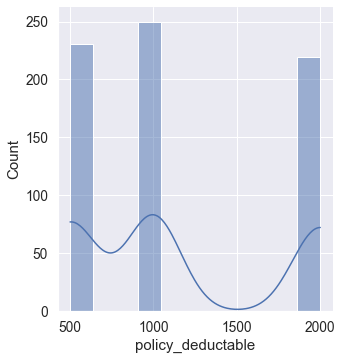

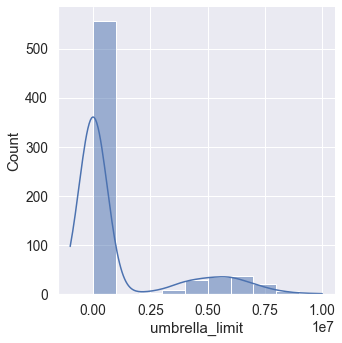

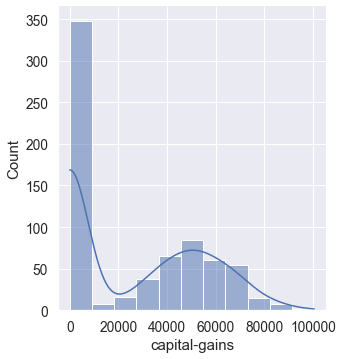

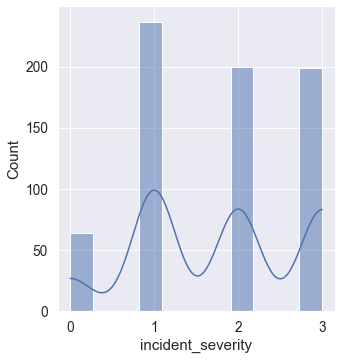

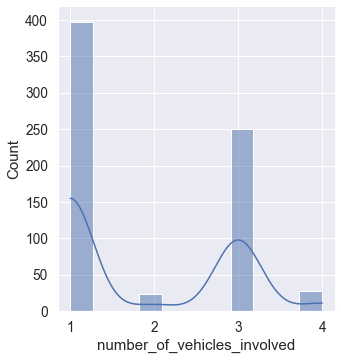

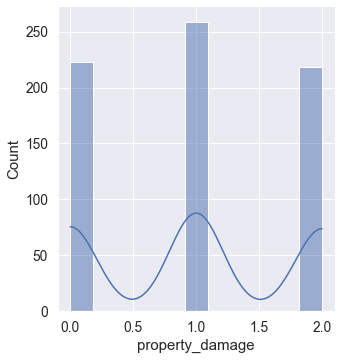

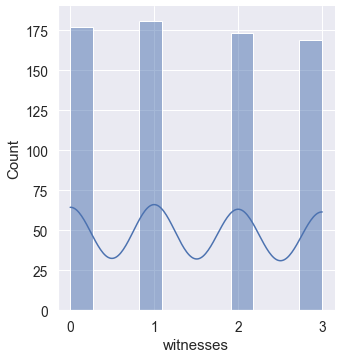

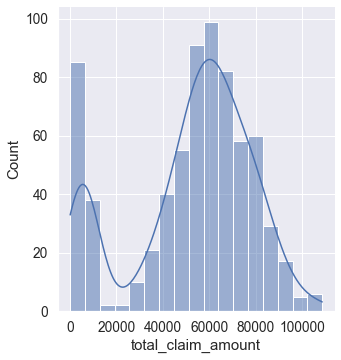

In [10]:
hist_nested_dict = defaultdict(dict)
# In order to represent the variable distribution in a histogram,
# initialize a dictionary that stores the values of the input variable and the target variable
for i,row in df.iterrows():
    for v in numerical_vars:
        if not v==y_name:
            try:
                hist_nested_dict[v]["x"].append(row[v])
                hist_nested_dict[v]["y"].append(row[y_name])
            except KeyError:
                hist_nested_dict[v]["x"] = [row[v]]
                hist_nested_dict[v]["y"] = [row[y_name]]

                
for col_key in hist_nested_dict.keys():
    try:
        x = hist_nested_dict[col_key]["x"]
        hist = sns.displot(data=df, x=hist_nested_dict[col_key]["x"], kind="hist", kde=True)
        hist.set(xlabel=col_key)
    except (ValueError, TypeError) as e:
        print("Variable: " + col_key)
        print(e)

Several numerical variables are quasi-categorical (e.g. `policy_deductable`, `incident_severity`), assuming a few discrete values. Even `total_claim_amount` does not present a clean normal curve. 

Therefore, we simply scale the data in the range [0,1]

In [11]:
df_1 = df.copy(deep=True)
scaler = preprocessing.MinMaxScaler()
df_1[numerical_vars] = scaler.fit_transform(df[numerical_vars])
df = df_1  # using a separate dataset to suppress warning

## 3.4 Categorical variables

We decide to examine two characteristics for each categorical variable:
- the number of unique values (i.e. categories)
- the strength of the association with the target variable, using Theil's U as a measure of nominal association

Eventually we have to apply a one-hot encoder on categorical variables, causing an expansion of the number of features.<br/>
We decide to keep only the categorical variables where the uncertainty coefficient is not exactly 0 (>0.01) and where the number of unique values is small enough (<20) to avoid an explosion of the number of features.

In [12]:
# Auxiliary functions taken from: https://www.kaggle.com/code/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival/notebook
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [13]:
categorical_variables = []
lts = []
for c in df.columns:
    if df[c].dtype == pd.CategoricalDtype:  # we examine categorical variables here, not numerical
        categorical_variables.append(c)
        u = theil_u(df[c].tolist(), df[y_name].tolist())
        lts.append((c, df[c].value_counts().count(), round(u,5)))
lts = sorted(lts, key=lambda tpl: tpl[2], reverse=True)
c_info_df = pd.DataFrame(lts, columns=["Variable", "N. unique values", "Uncertainty_coeff"])
display(c_info_df)

,Variable,N. unique values,Uncertainty_coeff
0,incident_type,4,0.01525
1,collision_type,4,0.01403
2,authorities_contacted,5,0.01123
3,auto_model,39,0.00910
4,incident_state,7,0.00654
5,auto_make,14,0.00355
6,insured_occupation,14,0.00329
7,insured_education_level,7,0.00145
8,insured_relationship,6,0.00143
9,policy_state,3,0.00125


In [14]:
cat_variables_to_drop = []
for i,row in c_info_df.iterrows():
    v = row["Variable"]
    num_categories = row["N. unique values"]
    u_coeff = row["Uncertainty_coeff"]
    if (num_categories > 20) or (u_coeff < 0.01):
        cat_variables_to_drop.append(v)
print("Dropping: " + str(cat_variables_to_drop))
df = df.drop(cat_variables_to_drop, axis=1)

Dropping: ['auto_model', 'incident_state', 'auto_make', 'insured_occupation', 'insured_education_level', 'insured_relationship', 'policy_state', 'incident_city', 'insured_sex']


In [15]:
cat_variables_to_encode = list(set(categorical_variables).difference(set(cat_variables_to_drop)))
md("""{} variables remain in the dataset: {} \n
We encode the {} categorical variables: {}"""
   .format(len(df.columns), list(df.columns), len(cat_variables_to_encode), str(cat_variables_to_encode)))


12 variables remain in the dataset: ['policy_deductable', 'umbrella_limit', 'capital-gains', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'number_of_vehicles_involved', 'property_damage', 'witnesses', 'total_claim_amount', 'fraud_reported'] 

We encode the 3 categorical variables: ['incident_type', 'authorities_contacted', 'collision_type']

In [16]:
df = pd.get_dummies(df, columns=cat_variables_to_encode)

In [17]:
df

,policy_deductable,umbrella_limit,capital-gains,incident_severity,number_of_vehicles_involved,property_damage,witnesses,total_claim_amount,fraud_reported,incident_type_Multi-vehicle Collision,...,incident_type_Vehicle Theft,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,collision_type_?,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision
0,0.333333,0.545455,0.598010,1.000000,0.000000,0.5,1.000000,0.531463,0.0,0,...,0,1,0,0,0,0,0,0,0,1
1,0.000000,0.090909,0.330348,0.333333,0.666667,0.5,0.333333,0.473335,0.0,1,...,0,0,0,0,1,0,0,0,0,1
2,0.333333,0.090909,0.000000,1.000000,0.000000,0.5,0.333333,0.430891,0.0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.000000,0.090909,0.000000,0.666667,0.666667,1.0,0.666667,0.631297,1.0,1,...,0,0,1,0,0,0,0,1,0,0
4,0.333333,0.090909,0.720398,1.000000,0.666667,1.0,0.333333,0.543089,0.0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.000000,0.090909,0.482587,0.666667,0.000000,0.5,1.000000,0.554254,1.0,0,...,0,1,0,0,0,0,0,1,0,0
696,0.000000,0.818182,0.000000,0.666667,0.666667,0.0,0.333333,0.650489,1.0,1,...,0,1,0,0,0,0,0,0,1,0
697,0.000000,0.090909,0.000000,0.333333,0.666667,0.0,0.000000,0.526112,0.0,1,...,0,0,1,0,0,0,0,0,1,0
698,1.000000,0.090909,0.469652,0.666667,0.666667,0.5,0.000000,0.330319,1.0,1,...,0,1,0,0,0,0,0,0,1,0


## 3.5 Training and test set

It is necessary to keep some data out of the training set, to check whether the model is able to generalize to unseen data.

The test set should have the same proportion of fraudulent vs. genuine claims as the whole dataset, which can be observed here:

In [18]:
df[y_name].value_counts()

0.0    519
1.0    181
Name: fraud_reported, dtype: int64

In [19]:
y = df[y_name].copy()
X = df.drop(y_name)
X, y

KeyError: "['fraud_reported'] not found in axis"